In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, SimpleRNN
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow import keras

df_train = pd.read_csv('fill_NA(mean)_ver2.csv')
df_train = df_train[(df_train['날짜'] != 20200229) & (df_train['날짜'] != 20200330)]

df_val = pd.read_csv('val_고침.csv')

df_test = pd.read_csv('test_고침.csv')

submit = pd.read_csv('sample_submission.csv')

date_cols = list(df_train.columns[:2])
road_cols = list(df_train.columns[2:])

2022-02-17 01:15:59.460348: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-17 01:15:59.460392: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import tensorflow as tf
tf.random.set_seed(2)

In [3]:
# https://hwao-story.tistory.com/15
window_size = 24 * 7

def create_dataset(signal_data, window_size = 1):
    dataX, dataY = [], []
    for i in range(len(signal_data) - window_size):
        dataX.append(signal_data.iloc[i:(i + window_size)])
        dataY.append(signal_data.iloc[i + window_size])
    return np.array(dataX), np.array(dataY)

In [4]:
def make_data_self(model, road):
    length = 24 * 7
    result = df_val[[road]][-window_size-1:]
    
    for i in range(length):
        result_X, result_y = create_dataset(result, window_size)
        predict = model.predict(result_X, batch_size = 16)[-1].astype(int)
        result.loc[len(result)] = predict

    return result[-length:].reset_index(drop = True)

In [5]:
early_stopping = EarlyStopping(monitor='val_loss', mode = 'min', verbose=1, patience = 60)

model = Sequential()
model.add(Dense(32, input_dim = window_size, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(8, activation = 'relu'))
model.add(Dense(4, activation = 'relu'))
model.add(Dense(1))

fitted_models = []

def fit_model_and_submit(road):
    train = df_train[[road]]
    val = df_val[[road]]
    test = df_test[[road]]
    
    X_train, y_train = create_dataset(train, window_size)
    X_val, y_val = create_dataset(val, window_size)
    X_test, y_test = create_dataset(test, window_size)

    model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')
    hist = model.fit(X_train, y_train, epochs = 500,
                batch_size = 16, shuffle=False, callbacks = [early_stopping], validation_data=(X_val, y_val))
    fitted_models.append(model)
    
    model_pred = make_data_self(model, road)
    submit[road] = model_pred

2022-02-17 01:16:04.945242: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-17 01:16:04.945314: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-17 01:16:04.945339: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (42ea0bd6da54): /proc/driver/nvidia/version does not exist
2022-02-17 01:16:04.945550: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
from tqdm import tqdm
for index in tqdm(range(len(road_cols))):
    road = road_cols[index]
    fit_model_and_submit(road)
    
submit

  0%|                                                                                            | 0/35 [00:00<?, ?it/s]

Epoch 1/500
194/194 [==============================] - 1s 2ms/step - loss: 7321157120.0000 - val_loss: 1703602816.0000
Epoch 2/500
194/194 [==============================] - 0s 2ms/step - loss: 2513693952.0000 - val_loss: 1353109632.0000
Epoch 3/500
194/194 [==============================] - 0s 2ms/step - loss: 2152520192.0000 - val_loss: 1118651392.0000
Epoch 4/500
194/194 [==============================] - 0s 2ms/step - loss: 1913557760.0000 - val_loss: 989194368.0000
Epoch 5/500
194/194 [==============================] - 0s 2ms/step - loss: 1769459456.0000 - val_loss: 870671424.0000
Epoch 6/500
194/194 [==============================] - 0s 2ms/step - loss: 1668302848.0000 - val_loss: 798133440.0000
Epoch 7/500
194/194 [==============================] - 0s 2ms/step - loss: 1573732224.0000 - val_loss: 724819264.0000
Epoch 8/500
194/194 [==============================] - 0s 2ms/step - loss: 1494730496.0000 - val_loss: 654472320.0000
Epoch 9/500
194/194 [==============================] 

194/194 [==============================] - 0s 1ms/step - loss: 284990400.0000 - val_loss: 204653472.0000
Epoch 140/500
194/194 [==============================] - 0s 1ms/step - loss: 299369792.0000 - val_loss: 201569008.0000
Epoch 141/500
194/194 [==============================] - 0s 1ms/step - loss: 307711360.0000 - val_loss: 220746160.0000
Epoch 142/500
194/194 [==============================] - 0s 1ms/step - loss: 302472320.0000 - val_loss: 237084672.0000
Epoch 143/500
194/194 [==============================] - 0s 1ms/step - loss: 290055456.0000 - val_loss: 212889120.0000
Epoch 144/500
194/194 [==============================] - 0s 1ms/step - loss: 283903712.0000 - val_loss: 209112064.0000
Epoch 145/500
194/194 [==============================] - 0s 1ms/step - loss: 286614208.0000 - val_loss: 211076000.0000
Epoch 146/500
194/194 [==============================] - 0s 2ms/step - loss: 297252960.0000 - val_loss: 200796400.0000
Epoch 147/500
194/194 [==============================] - 0s 1m

Epoch 208/500
194/194 [==============================] - 0s 1ms/step - loss: 206403840.0000 - val_loss: 163219216.0000
Epoch 209/500
194/194 [==============================] - 0s 1ms/step - loss: 209368560.0000 - val_loss: 150990256.0000
Epoch 210/500
194/194 [==============================] - 0s 1ms/step - loss: 206016848.0000 - val_loss: 155979552.0000
Epoch 211/500
194/194 [==============================] - 0s 1ms/step - loss: 204927120.0000 - val_loss: 165913376.0000
Epoch 212/500
194/194 [==============================] - 0s 1ms/step - loss: 211938496.0000 - val_loss: 158465392.0000
Epoch 213/500
194/194 [==============================] - 0s 1ms/step - loss: 201889008.0000 - val_loss: 143315984.0000
Epoch 214/500
194/194 [==============================] - 0s 2ms/step - loss: 211407856.0000 - val_loss: 180595024.0000
Epoch 215/500
194/194 [==============================] - 0s 1ms/step - loss: 218341632.0000 - val_loss: 143819488.0000
Epoch 216/500
194/194 [=========================

Epoch 277/500
194/194 [==============================] - 0s 2ms/step - loss: 186781792.0000 - val_loss: 140642352.0000
Epoch 278/500
194/194 [==============================] - 0s 1ms/step - loss: 177534512.0000 - val_loss: 145725584.0000
Epoch 279/500
194/194 [==============================] - 0s 1ms/step - loss: 195982416.0000 - val_loss: 149413680.0000
Epoch 280/500
194/194 [==============================] - 0s 1ms/step - loss: 174805104.0000 - val_loss: 161579232.0000
Epoch 281/500
194/194 [==============================] - 0s 1ms/step - loss: 182885168.0000 - val_loss: 143912656.0000
Epoch 282/500
194/194 [==============================] - 0s 1ms/step - loss: 203582464.0000 - val_loss: 157567264.0000
Epoch 283/500
194/194 [==============================] - 0s 1ms/step - loss: 180127344.0000 - val_loss: 154313872.0000
Epoch 284/500
194/194 [==============================] - 0s 1ms/step - loss: 175372208.0000 - val_loss: 154750192.0000
Epoch 285/500
194/194 [=========================

  3%|██▎                                                                                | 1/35 [01:43<58:39, 103.51s/it]

Epoch 1/500
194/194 [==============================] - 1s 2ms/step - loss: 39222620.0000 - val_loss: 22179284.0000
Epoch 2/500
194/194 [==============================] - 0s 1ms/step - loss: 30500244.0000 - val_loss: 25330702.0000
Epoch 3/500
194/194 [==============================] - 0s 1ms/step - loss: 28129188.0000 - val_loss: 23250638.0000
Epoch 4/500
194/194 [==============================] - 0s 1ms/step - loss: 26936506.0000 - val_loss: 23873546.0000
Epoch 5/500
194/194 [==============================] - 0s 1ms/step - loss: 25701540.0000 - val_loss: 25445372.0000
Epoch 6/500
194/194 [==============================] - 0s 1ms/step - loss: 25466864.0000 - val_loss: 24014440.0000
Epoch 7/500
194/194 [==============================] - 0s 1ms/step - loss: 24331378.0000 - val_loss: 24750250.0000
Epoch 8/500
194/194 [==============================] - 0s 1ms/step - loss: 24028642.0000 - val_loss: 24927562.0000
Epoch 9/500
194/194 [==============================] - 0s 1ms/step - loss: 23663

  6%|████▊                                                                               | 2/35 [02:28<38:06, 69.30s/it]

Epoch 1/500
194/194 [==============================] - 1s 2ms/step - loss: 1185721.1250 - val_loss: 2101329.2500
Epoch 2/500
194/194 [==============================] - 0s 1ms/step - loss: 883978.3125 - val_loss: 2075844.3750
Epoch 3/500
194/194 [==============================] - 0s 2ms/step - loss: 778265.3750 - val_loss: 2067002.6250
Epoch 4/500
194/194 [==============================] - 0s 1ms/step - loss: 703814.4375 - val_loss: 1989204.6250
Epoch 5/500
194/194 [==============================] - 0s 1ms/step - loss: 665799.1250 - val_loss: 2032525.5000
Epoch 6/500
194/194 [==============================] - 0s 1ms/step - loss: 606689.7500 - val_loss: 2007632.0000
Epoch 7/500
194/194 [==============================] - 0s 1ms/step - loss: 573664.3125 - val_loss: 1989272.3750
Epoch 8/500
194/194 [==============================] - 0s 1ms/step - loss: 544810.3125 - val_loss: 1952839.7500
Epoch 9/500
194/194 [==============================] - 0s 2ms/step - loss: 545526.3125 - val_loss: 1975

  9%|███████▏                                                                            | 3/35 [02:55<26:35, 49.84s/it]

Epoch 1/500
194/194 [==============================] - 1s 2ms/step - loss: 3239572.7500 - val_loss: 3616508.5000
Epoch 2/500
194/194 [==============================] - 0s 1ms/step - loss: 2802170.5000 - val_loss: 4508473.5000
Epoch 3/500
194/194 [==============================] - 0s 1ms/step - loss: 2582200.0000 - val_loss: 4964786.5000
Epoch 4/500
194/194 [==============================] - 0s 1ms/step - loss: 2695228.7500 - val_loss: 4519909.5000
Epoch 5/500
194/194 [==============================] - 0s 1ms/step - loss: 2596809.0000 - val_loss: 4125290.0000
Epoch 6/500
194/194 [==============================] - 0s 1ms/step - loss: 2717823.2500 - val_loss: 3716381.2500
Epoch 7/500
194/194 [==============================] - 0s 1ms/step - loss: 2651481.5000 - val_loss: 4875974.0000
Epoch 8/500
194/194 [==============================] - 0s 1ms/step - loss: 2729335.0000 - val_loss: 3466466.2500
Epoch 9/500
194/194 [==============================] - 0s 1ms/step - loss: 2562372.2500 - val_lo

Epoch 73/500
194/194 [==============================] - 0s 1ms/step - loss: 2101357.2500 - val_loss: 3692557.7500
Epoch 74/500
194/194 [==============================] - 0s 1ms/step - loss: 2101229.2500 - val_loss: 3194112.0000
Epoch 75/500
194/194 [==============================] - 0s 1ms/step - loss: 2440694.0000 - val_loss: 4230126.5000
Epoch 76/500
194/194 [==============================] - 0s 1ms/step - loss: 2317745.0000 - val_loss: 3540713.5000
Epoch 77/500
194/194 [==============================] - 0s 1ms/step - loss: 2643947.2500 - val_loss: 4125332.2500
Epoch 78/500
194/194 [==============================] - 0s 1ms/step - loss: 2215933.2500 - val_loss: 3448448.0000
Epoch 79/500
194/194 [==============================] - 0s 1ms/step - loss: 2380342.5000 - val_loss: 3680575.5000
Epoch 80/500
194/194 [==============================] - 0s 1ms/step - loss: 2143466.2500 - val_loss: 3135006.5000
Epoch 81/500
194/194 [==============================] - 0s 1ms/step - loss: 2393226.5000

 11%|█████████▌                                                                          | 4/35 [03:58<28:20, 54.86s/it]

Epoch 1/500
194/194 [==============================] - 1s 2ms/step - loss: 671792.0625 - val_loss: 1836436.6250
Epoch 2/500
194/194 [==============================] - 0s 1ms/step - loss: 510101.2812 - val_loss: 1784441.5000
Epoch 3/500
194/194 [==============================] - 0s 2ms/step - loss: 490484.3125 - val_loss: 1716172.2500
Epoch 4/500
194/194 [==============================] - 0s 1ms/step - loss: 455627.6562 - val_loss: 1707602.2500
Epoch 5/500
194/194 [==============================] - 0s 2ms/step - loss: 437423.8438 - val_loss: 1658561.1250
Epoch 6/500
194/194 [==============================] - 0s 1ms/step - loss: 433804.1875 - val_loss: 1684587.0000
Epoch 7/500
194/194 [==============================] - 0s 1ms/step - loss: 409416.4688 - val_loss: 1724266.5000
Epoch 8/500
194/194 [==============================] - 0s 1ms/step - loss: 417498.4062 - val_loss: 1738315.0000
Epoch 9/500
194/194 [==============================] - 0s 1ms/step - loss: 390607.5000 - val_loss: 15442

 14%|████████████                                                                        | 5/35 [04:31<23:37, 47.26s/it]

Epoch 1/500
194/194 [==============================] - 1s 2ms/step - loss: 280952.0938 - val_loss: 893541.6875
Epoch 2/500
194/194 [==============================] - 0s 1ms/step - loss: 260584.3125 - val_loss: 887100.6875
Epoch 3/500
194/194 [==============================] - 0s 1ms/step - loss: 248878.4219 - val_loss: 904003.2500
Epoch 4/500
194/194 [==============================] - 0s 2ms/step - loss: 242698.8594 - val_loss: 964474.1875
Epoch 5/500
194/194 [==============================] - 0s 1ms/step - loss: 239172.4062 - val_loss: 955824.3125
Epoch 6/500
194/194 [==============================] - 0s 1ms/step - loss: 233935.2969 - val_loss: 949778.6875
Epoch 7/500
194/194 [==============================] - 0s 1ms/step - loss: 230622.9688 - val_loss: 957745.8125
Epoch 8/500
194/194 [==============================] - 0s 1ms/step - loss: 227420.8438 - val_loss: 893240.5000
Epoch 9/500
194/194 [==============================] - 0s 1ms/step - loss: 221109.1719 - val_loss: 838852.5625
E

 17%|██████████████▍                                                                     | 6/35 [05:08<21:01, 43.48s/it]

Epoch 1/500
194/194 [==============================] - 1s 2ms/step - loss: 101884552.0000 - val_loss: 71511944.0000
Epoch 2/500
194/194 [==============================] - 0s 1ms/step - loss: 71471448.0000 - val_loss: 59429680.0000
Epoch 3/500
194/194 [==============================] - 0s 1ms/step - loss: 64791364.0000 - val_loss: 50693184.0000
Epoch 4/500
194/194 [==============================] - 0s 1ms/step - loss: 60451844.0000 - val_loss: 49368432.0000
Epoch 5/500
194/194 [==============================] - 0s 1ms/step - loss: 55290964.0000 - val_loss: 45756496.0000
Epoch 6/500
194/194 [==============================] - 0s 1ms/step - loss: 53036684.0000 - val_loss: 49067028.0000
Epoch 7/500
194/194 [==============================] - 0s 1ms/step - loss: 49641900.0000 - val_loss: 44721516.0000
Epoch 8/500
194/194 [==============================] - 0s 1ms/step - loss: 49689752.0000 - val_loss: 42173488.0000
Epoch 9/500
194/194 [==============================] - 0s 1ms/step - loss: 4937

 20%|████████████████▊                                                                   | 7/35 [05:52<20:29, 43.93s/it]

Epoch 1/500
194/194 [==============================] - 1s 2ms/step - loss: 147921.8906 - val_loss: 87978.7344
Epoch 2/500
194/194 [==============================] - 0s 2ms/step - loss: 123349.1406 - val_loss: 90740.2812
Epoch 3/500
194/194 [==============================] - 0s 2ms/step - loss: 118415.3984 - val_loss: 89582.9609
Epoch 4/500
194/194 [==============================] - 0s 2ms/step - loss: 115559.4219 - val_loss: 85834.2109
Epoch 5/500
194/194 [==============================] - 0s 2ms/step - loss: 112536.6328 - val_loss: 92426.5625
Epoch 6/500
194/194 [==============================] - 0s 2ms/step - loss: 108650.6641 - val_loss: 90585.7031
Epoch 7/500
194/194 [==============================] - 0s 2ms/step - loss: 104222.5078 - val_loss: 87246.3047
Epoch 8/500
194/194 [==============================] - 0s 2ms/step - loss: 102645.8594 - val_loss: 84732.1406
Epoch 9/500
194/194 [==============================] - 0s 2ms/step - loss: 100034.4375 - val_loss: 98665.2891
Epoch 10/5

 23%|███████████████████▏                                                                | 8/35 [06:27<18:27, 41.03s/it]

Epoch 1/500
194/194 [==============================] - 1s 2ms/step - loss: 2210900.7500 - val_loss: 1840845.1250
Epoch 2/500
194/194 [==============================] - 0s 2ms/step - loss: 1654075.7500 - val_loss: 1503801.5000
Epoch 3/500
194/194 [==============================] - 0s 2ms/step - loss: 1490979.3750 - val_loss: 1138033.3750
Epoch 4/500
194/194 [==============================] - 0s 2ms/step - loss: 1402077.1250 - val_loss: 1105611.6250
Epoch 5/500
194/194 [==============================] - 0s 2ms/step - loss: 1350213.8750 - val_loss: 1123066.8750
Epoch 6/500
194/194 [==============================] - 0s 2ms/step - loss: 1316883.8750 - val_loss: 1044893.2500
Epoch 7/500
194/194 [==============================] - 0s 2ms/step - loss: 1248544.8750 - val_loss: 981727.8125
Epoch 8/500
194/194 [==============================] - 0s 2ms/step - loss: 1253251.7500 - val_loss: 888866.0000
Epoch 9/500
194/194 [==============================] - 0s 2ms/step - loss: 1227461.5000 - val_loss

Epoch 74/500
194/194 [==============================] - 0s 1ms/step - loss: 932877.2500 - val_loss: 609375.4375
Epoch 75/500
194/194 [==============================] - 0s 2ms/step - loss: 925569.8125 - val_loss: 646191.8750
Epoch 76/500
194/194 [==============================] - 0s 2ms/step - loss: 919952.0625 - val_loss: 632343.5000
Epoch 77/500
194/194 [==============================] - 0s 1ms/step - loss: 907959.8125 - val_loss: 615451.1250
Epoch 78/500
194/194 [==============================] - 0s 2ms/step - loss: 891048.1250 - val_loss: 636227.7500
Epoch 79/500
194/194 [==============================] - 0s 2ms/step - loss: 904935.5000 - val_loss: 605162.1875
Epoch 80/500
194/194 [==============================] - 0s 2ms/step - loss: 893049.0000 - val_loss: 644589.3125
Epoch 81/500
194/194 [==============================] - 0s 2ms/step - loss: 909314.5000 - val_loss: 696190.0625
Epoch 82/500
194/194 [==============================] - 0s 2ms/step - loss: 919849.2500 - val_loss: 6081

 26%|█████████████████████▌                                                              | 9/35 [07:17<19:00, 43.86s/it]

Epoch 1/500
194/194 [==============================] - 1s 2ms/step - loss: 477909.7812 - val_loss: 289052.5000
Epoch 2/500
194/194 [==============================] - 0s 1ms/step - loss: 414036.7500 - val_loss: 258646.4062
Epoch 3/500
194/194 [==============================] - 0s 1ms/step - loss: 380586.9688 - val_loss: 255594.5781
Epoch 4/500
194/194 [==============================] - 0s 1ms/step - loss: 389023.3750 - val_loss: 244022.5000
Epoch 5/500
194/194 [==============================] - 0s 2ms/step - loss: 370124.9375 - val_loss: 235664.0938
Epoch 6/500
194/194 [==============================] - 0s 1ms/step - loss: 359690.8438 - val_loss: 244303.4688
Epoch 7/500
194/194 [==============================] - 0s 2ms/step - loss: 347963.5312 - val_loss: 218684.2812
Epoch 8/500
194/194 [==============================] - 0s 2ms/step - loss: 328751.0000 - val_loss: 221989.0469
Epoch 9/500
194/194 [==============================] - 0s 2ms/step - loss: 313624.2812 - val_loss: 220647.7344
E

 29%|███████████████████████▋                                                           | 10/35 [08:04<18:35, 44.62s/it]

Epoch 1/500
194/194 [==============================] - 1s 2ms/step - loss: 17432656.0000 - val_loss: 32052282.0000
Epoch 2/500
194/194 [==============================] - 0s 2ms/step - loss: 14063402.0000 - val_loss: 32203788.0000
Epoch 3/500
194/194 [==============================] - 0s 2ms/step - loss: 12200379.0000 - val_loss: 30406076.0000
Epoch 4/500
194/194 [==============================] - 0s 2ms/step - loss: 11601587.0000 - val_loss: 28783510.0000
Epoch 5/500
194/194 [==============================] - 0s 2ms/step - loss: 10968467.0000 - val_loss: 28912152.0000
Epoch 6/500
194/194 [==============================] - 0s 2ms/step - loss: 10666910.0000 - val_loss: 28488316.0000
Epoch 7/500
194/194 [==============================] - 0s 2ms/step - loss: 10526143.0000 - val_loss: 28741796.0000
Epoch 8/500
194/194 [==============================] - 0s 2ms/step - loss: 10208435.0000 - val_loss: 28120058.0000
Epoch 9/500
194/194 [==============================] - 0s 2ms/step - loss: 10062

 31%|██████████████████████████                                                         | 11/35 [08:33<16:01, 40.07s/it]

Epoch 1/500
194/194 [==============================] - 1s 2ms/step - loss: 1496181.2500 - val_loss: 2672277.0000
Epoch 2/500
194/194 [==============================] - 0s 2ms/step - loss: 1310925.1250 - val_loss: 2553140.5000
Epoch 3/500
194/194 [==============================] - 0s 2ms/step - loss: 1164790.6250 - val_loss: 2455480.0000
Epoch 4/500
194/194 [==============================] - 0s 2ms/step - loss: 1098613.8750 - val_loss: 2452952.5000
Epoch 5/500
194/194 [==============================] - 0s 1ms/step - loss: 1078497.5000 - val_loss: 2360267.5000
Epoch 6/500
194/194 [==============================] - 0s 2ms/step - loss: 1052811.8750 - val_loss: 2371253.0000
Epoch 7/500
194/194 [==============================] - 0s 1ms/step - loss: 1019441.1250 - val_loss: 2383182.0000
Epoch 8/500
194/194 [==============================] - 0s 2ms/step - loss: 1001160.6875 - val_loss: 2343275.2500
Epoch 9/500
194/194 [==============================] - 0s 1ms/step - loss: 999626.4375 - val_los

 34%|████████████████████████████▍                                                      | 12/35 [09:00<13:51, 36.14s/it]

Epoch 1/500
194/194 [==============================] - 1s 2ms/step - loss: 3066301.5000 - val_loss: 2439053.2500
Epoch 2/500
194/194 [==============================] - 0s 1ms/step - loss: 2880228.2500 - val_loss: 2344030.2500
Epoch 3/500
194/194 [==============================] - 0s 1ms/step - loss: 2748951.2500 - val_loss: 2279869.2500
Epoch 4/500
194/194 [==============================] - 0s 1ms/step - loss: 2659584.2500 - val_loss: 2409447.0000
Epoch 5/500
194/194 [==============================] - 0s 1ms/step - loss: 2569581.2500 - val_loss: 2492026.0000
Epoch 6/500
194/194 [==============================] - 0s 1ms/step - loss: 2531460.0000 - val_loss: 2589222.5000
Epoch 7/500
194/194 [==============================] - 0s 1ms/step - loss: 2501494.5000 - val_loss: 2494113.7500
Epoch 8/500
194/194 [==============================] - 0s 1ms/step - loss: 2460294.2500 - val_loss: 2500249.7500
Epoch 9/500
194/194 [==============================] - 0s 1ms/step - loss: 2448032.5000 - val_lo

Epoch 73/500
194/194 [==============================] - 0s 1ms/step - loss: 2167712.5000 - val_loss: 2024012.3750
Epoch 74/500
194/194 [==============================] - 0s 1ms/step - loss: 2093099.8750 - val_loss: 1976107.3750
Epoch 75/500
194/194 [==============================] - 0s 1ms/step - loss: 1976487.3750 - val_loss: 2108700.5000
Epoch 76/500
194/194 [==============================] - 0s 1ms/step - loss: 2018665.5000 - val_loss: 2030510.6250
Epoch 77/500
194/194 [==============================] - 0s 1ms/step - loss: 2059624.6250 - val_loss: 1998754.2500
Epoch 78/500
194/194 [==============================] - 0s 1ms/step - loss: 2049202.2500 - val_loss: 1971837.1250
Epoch 79/500
194/194 [==============================] - 0s 1ms/step - loss: 2026632.3750 - val_loss: 1957869.1250
Epoch 80/500
194/194 [==============================] - 0s 1ms/step - loss: 2056908.8750 - val_loss: 1900568.6250
Epoch 81/500
194/194 [==============================] - 0s 1ms/step - loss: 2012329.6250

 37%|██████████████████████████████▊                                                    | 13/35 [09:50<14:43, 40.15s/it]

Epoch 1/500
194/194 [==============================] - 1s 2ms/step - loss: 2203066.5000 - val_loss: 3814260.2500
Epoch 2/500
194/194 [==============================] - 0s 2ms/step - loss: 1971911.6250 - val_loss: 3331337.5000
Epoch 3/500
194/194 [==============================] - 0s 2ms/step - loss: 1852508.0000 - val_loss: 3321615.5000
Epoch 4/500
194/194 [==============================] - 0s 2ms/step - loss: 1759738.3750 - val_loss: 2975836.5000
Epoch 5/500
194/194 [==============================] - 0s 2ms/step - loss: 1723926.0000 - val_loss: 3102187.2500
Epoch 6/500
194/194 [==============================] - 0s 1ms/step - loss: 1690322.6250 - val_loss: 2795074.5000
Epoch 7/500
194/194 [==============================] - 0s 1ms/step - loss: 1644855.6250 - val_loss: 2775660.0000
Epoch 8/500
194/194 [==============================] - 0s 1ms/step - loss: 1617352.0000 - val_loss: 2651374.7500
Epoch 9/500
194/194 [==============================] - 0s 2ms/step - loss: 1586787.3750 - val_lo

Epoch 73/500
194/194 [==============================] - 0s 1ms/step - loss: 1243806.5000 - val_loss: 3580018.0000
Epoch 74/500
194/194 [==============================] - 0s 1ms/step - loss: 1223654.7500 - val_loss: 3711535.5000
Epoch 75/500
194/194 [==============================] - 0s 2ms/step - loss: 1221818.7500 - val_loss: 3612392.5000
Epoch 76/500
194/194 [==============================] - 0s 2ms/step - loss: 1208423.7500 - val_loss: 3717614.5000
Epoch 77/500
194/194 [==============================] - 0s 2ms/step - loss: 1209760.0000 - val_loss: 3366542.5000
Epoch 78/500
194/194 [==============================] - 0s 1ms/step - loss: 1209079.3750 - val_loss: 3489626.7500
Epoch 78: early stopping


 40%|█████████████████████████████████▏                                                 | 14/35 [10:19<12:50, 36.70s/it]

Epoch 1/500
194/194 [==============================] - 1s 2ms/step - loss: 6204606.5000 - val_loss: 4720029.5000
Epoch 2/500
194/194 [==============================] - 0s 1ms/step - loss: 4859106.0000 - val_loss: 4605684.0000
Epoch 3/500
194/194 [==============================] - 0s 1ms/step - loss: 4523373.0000 - val_loss: 4468908.5000
Epoch 4/500
194/194 [==============================] - 0s 1ms/step - loss: 4232503.0000 - val_loss: 4352381.5000
Epoch 5/500
194/194 [==============================] - 0s 1ms/step - loss: 4074253.0000 - val_loss: 4106674.2500
Epoch 6/500
194/194 [==============================] - 0s 1ms/step - loss: 3840483.0000 - val_loss: 3811936.5000
Epoch 7/500
194/194 [==============================] - 0s 1ms/step - loss: 3693752.2500 - val_loss: 3620632.5000
Epoch 8/500
194/194 [==============================] - 0s 1ms/step - loss: 3512270.0000 - val_loss: 3420467.7500
Epoch 9/500
194/194 [==============================] - 0s 1ms/step - loss: 3528816.7500 - val_lo

Epoch 73/500
194/194 [==============================] - 0s 1ms/step - loss: 2381335.7500 - val_loss: 2767066.2500
Epoch 74/500
194/194 [==============================] - 0s 1ms/step - loss: 2395635.7500 - val_loss: 2628458.2500
Epoch 75/500
194/194 [==============================] - 0s 1ms/step - loss: 2378554.0000 - val_loss: 2568275.0000
Epoch 76/500
194/194 [==============================] - 0s 1ms/step - loss: 2378463.0000 - val_loss: 2618804.5000
Epoch 77/500
194/194 [==============================] - 0s 1ms/step - loss: 2384421.0000 - val_loss: 2467736.5000
Epoch 78/500
194/194 [==============================] - 0s 1ms/step - loss: 2370749.2500 - val_loss: 2650189.2500
Epoch 79/500
194/194 [==============================] - 0s 1ms/step - loss: 2410790.7500 - val_loss: 2410435.5000
Epoch 80/500
194/194 [==============================] - 0s 1ms/step - loss: 2393609.5000 - val_loss: 2514536.7500
Epoch 81/500
194/194 [==============================] - 0s 1ms/step - loss: 2398488.7500

194/194 [==============================] - 0s 2ms/step - loss: 1953399.8750 - val_loss: 2931201.7500
Epoch 216/500
194/194 [==============================] - 0s 2ms/step - loss: 1969309.1250 - val_loss: 2697864.5000
Epoch 217/500
194/194 [==============================] - 0s 2ms/step - loss: 2049808.2500 - val_loss: 2915933.7500
Epoch 218/500
194/194 [==============================] - 0s 2ms/step - loss: 2063813.7500 - val_loss: 2894133.0000
Epoch 219/500
194/194 [==============================] - 0s 2ms/step - loss: 2101954.7500 - val_loss: 2456039.7500
Epoch 220/500
194/194 [==============================] - 0s 2ms/step - loss: 1938638.8750 - val_loss: 2401506.0000
Epoch 221/500
194/194 [==============================] - 0s 2ms/step - loss: 2165275.0000 - val_loss: 2699858.5000
Epoch 222/500
194/194 [==============================] - 0s 1ms/step - loss: 2049710.0000 - val_loss: 4096728.5000
Epoch 223/500
194/194 [==============================] - 0s 1ms/step - loss: 2101968.7500 - va

 43%|███████████████████████████████████▌                                               | 15/35 [11:32<15:53, 47.68s/it]

Epoch 1/500
194/194 [==============================] - 1s 2ms/step - loss: 18959988.0000 - val_loss: 11967543.0000
Epoch 2/500
194/194 [==============================] - 0s 2ms/step - loss: 16736170.0000 - val_loss: 11101560.0000
Epoch 3/500
194/194 [==============================] - 0s 2ms/step - loss: 16240100.0000 - val_loss: 10432931.0000
Epoch 4/500
194/194 [==============================] - 0s 1ms/step - loss: 15959498.0000 - val_loss: 8969322.0000
Epoch 5/500
194/194 [==============================] - 0s 1ms/step - loss: 15461928.0000 - val_loss: 9744290.0000
Epoch 6/500
194/194 [==============================] - 0s 1ms/step - loss: 15030955.0000 - val_loss: 9232420.0000
Epoch 7/500
194/194 [==============================] - 0s 1ms/step - loss: 14812938.0000 - val_loss: 8835747.0000
Epoch 8/500
194/194 [==============================] - 0s 1ms/step - loss: 15028135.0000 - val_loss: 9031214.0000
Epoch 9/500
194/194 [==============================] - 0s 2ms/step - loss: 14637269.0

 46%|█████████████████████████████████████▉                                             | 16/35 [12:10<14:13, 44.93s/it]

Epoch 1/500
194/194 [==============================] - 1s 2ms/step - loss: 651416.1250 - val_loss: 725553.1250
Epoch 2/500
194/194 [==============================] - 0s 1ms/step - loss: 620391.1875 - val_loss: 697297.3125
Epoch 3/500
194/194 [==============================] - 0s 1ms/step - loss: 609407.4375 - val_loss: 689405.0625
Epoch 4/500
194/194 [==============================] - 0s 1ms/step - loss: 603439.8750 - val_loss: 696043.8125
Epoch 5/500
194/194 [==============================] - 0s 1ms/step - loss: 606021.3750 - val_loss: 690170.4375
Epoch 6/500
194/194 [==============================] - 0s 1ms/step - loss: 596247.6250 - val_loss: 691823.1250
Epoch 7/500
194/194 [==============================] - 0s 1ms/step - loss: 593802.5625 - val_loss: 688554.0000
Epoch 8/500
194/194 [==============================] - 0s 1ms/step - loss: 589118.3750 - val_loss: 687306.8750
Epoch 9/500
194/194 [==============================] - 0s 1ms/step - loss: 588907.7500 - val_loss: 676742.5000
E

 49%|████████████████████████████████████████▎                                          | 17/35 [12:45<12:31, 41.73s/it]

Epoch 1/500
194/194 [==============================] - 1s 2ms/step - loss: 4301369.0000 - val_loss: 5973804.5000
Epoch 2/500
194/194 [==============================] - 0s 2ms/step - loss: 3804135.5000 - val_loss: 5838978.5000
Epoch 3/500
194/194 [==============================] - 0s 1ms/step - loss: 3593902.2500 - val_loss: 5876878.0000
Epoch 4/500
194/194 [==============================] - 0s 1ms/step - loss: 3425005.5000 - val_loss: 5807939.0000
Epoch 5/500
194/194 [==============================] - 0s 1ms/step - loss: 3293290.5000 - val_loss: 5891735.0000
Epoch 6/500
194/194 [==============================] - 0s 1ms/step - loss: 3224728.5000 - val_loss: 5896457.5000
Epoch 7/500
194/194 [==============================] - 0s 1ms/step - loss: 3176733.5000 - val_loss: 5905873.0000
Epoch 8/500
194/194 [==============================] - 0s 1ms/step - loss: 3113821.5000 - val_loss: 6115525.5000
Epoch 9/500
194/194 [==============================] - 0s 1ms/step - loss: 3047740.2500 - val_lo

 51%|██████████████████████████████████████████▋                                        | 18/35 [13:09<10:20, 36.53s/it]

Epoch 1/500
194/194 [==============================] - 1s 2ms/step - loss: 15285280.0000 - val_loss: 10000190.0000
Epoch 2/500
194/194 [==============================] - 0s 1ms/step - loss: 13457083.0000 - val_loss: 9847004.0000
Epoch 3/500
194/194 [==============================] - 0s 2ms/step - loss: 12218916.0000 - val_loss: 9137373.0000
Epoch 4/500
194/194 [==============================] - 0s 1ms/step - loss: 11792295.0000 - val_loss: 8988869.0000
Epoch 5/500
194/194 [==============================] - 0s 1ms/step - loss: 11161013.0000 - val_loss: 8837334.0000
Epoch 6/500
194/194 [==============================] - 0s 1ms/step - loss: 10858014.0000 - val_loss: 10082944.0000
Epoch 7/500
194/194 [==============================] - 0s 2ms/step - loss: 10614881.0000 - val_loss: 7623040.0000
Epoch 8/500
194/194 [==============================] - 0s 1ms/step - loss: 10353350.0000 - val_loss: 7434339.0000
Epoch 9/500
194/194 [==============================] - 0s 1ms/step - loss: 10311976.00

Epoch 73/500
194/194 [==============================] - 0s 1ms/step - loss: 6992980.5000 - val_loss: 5364653.0000
Epoch 74/500
194/194 [==============================] - 0s 1ms/step - loss: 6911136.0000 - val_loss: 5480401.0000
Epoch 75/500
194/194 [==============================] - 0s 1ms/step - loss: 6986746.5000 - val_loss: 5904468.0000
Epoch 76/500
194/194 [==============================] - 0s 1ms/step - loss: 6986836.0000 - val_loss: 5618256.0000
Epoch 77/500
194/194 [==============================] - 0s 1ms/step - loss: 6825033.0000 - val_loss: 5675961.0000
Epoch 78/500
194/194 [==============================] - 0s 1ms/step - loss: 6958544.5000 - val_loss: 6011165.0000
Epoch 79/500
194/194 [==============================] - 0s 1ms/step - loss: 6941856.5000 - val_loss: 5234730.0000
Epoch 80/500
194/194 [==============================] - 0s 1ms/step - loss: 7138810.5000 - val_loss: 4765205.5000
Epoch 81/500
194/194 [==============================] - 0s 2ms/step - loss: 6948338.0000

 54%|█████████████████████████████████████████████                                      | 19/35 [14:11<11:49, 44.33s/it]

Epoch 1/500
194/194 [==============================] - 1s 2ms/step - loss: 33987732.0000 - val_loss: 19587046.0000
Epoch 2/500
194/194 [==============================] - 0s 1ms/step - loss: 29844348.0000 - val_loss: 17768732.0000
Epoch 3/500
194/194 [==============================] - 0s 2ms/step - loss: 27896514.0000 - val_loss: 16218856.0000
Epoch 4/500
194/194 [==============================] - 0s 1ms/step - loss: 26322012.0000 - val_loss: 16349801.0000
Epoch 5/500
194/194 [==============================] - 0s 1ms/step - loss: 25696624.0000 - val_loss: 15944212.0000
Epoch 6/500
194/194 [==============================] - 0s 1ms/step - loss: 25032432.0000 - val_loss: 15634504.0000
Epoch 7/500
194/194 [==============================] - 0s 1ms/step - loss: 24662280.0000 - val_loss: 15352279.0000
Epoch 8/500
194/194 [==============================] - 0s 1ms/step - loss: 23726484.0000 - val_loss: 15054744.0000
Epoch 9/500
194/194 [==============================] - 0s 1ms/step - loss: 23374

 57%|███████████████████████████████████████████████▍                                   | 20/35 [14:52<10:49, 43.32s/it]

Epoch 1/500
194/194 [==============================] - 1s 2ms/step - loss: 26572128.0000 - val_loss: 14804259.0000
Epoch 2/500
194/194 [==============================] - 0s 1ms/step - loss: 20337296.0000 - val_loss: 11524969.0000
Epoch 3/500
194/194 [==============================] - 0s 2ms/step - loss: 18254680.0000 - val_loss: 13331445.0000
Epoch 4/500
194/194 [==============================] - 0s 2ms/step - loss: 17007532.0000 - val_loss: 11961467.0000
Epoch 5/500
194/194 [==============================] - 0s 2ms/step - loss: 17191790.0000 - val_loss: 12534606.0000
Epoch 6/500
194/194 [==============================] - 0s 2ms/step - loss: 16421859.0000 - val_loss: 11704436.0000
Epoch 7/500
194/194 [==============================] - 0s 2ms/step - loss: 16207368.0000 - val_loss: 12167230.0000
Epoch 8/500
194/194 [==============================] - 0s 2ms/step - loss: 15498425.0000 - val_loss: 11485117.0000
Epoch 9/500
194/194 [==============================] - 0s 2ms/step - loss: 15324

Epoch 72/500
194/194 [==============================] - 0s 2ms/step - loss: 10641422.0000 - val_loss: 11195709.0000
Epoch 73/500
194/194 [==============================] - 0s 2ms/step - loss: 10948087.0000 - val_loss: 11110721.0000
Epoch 74/500
194/194 [==============================] - 0s 2ms/step - loss: 10694211.0000 - val_loss: 10536092.0000
Epoch 75/500
194/194 [==============================] - 0s 2ms/step - loss: 10549792.0000 - val_loss: 10660116.0000
Epoch 76/500
194/194 [==============================] - 0s 2ms/step - loss: 10752850.0000 - val_loss: 10709028.0000
Epoch 77/500
194/194 [==============================] - 0s 2ms/step - loss: 10685390.0000 - val_loss: 10490101.0000
Epoch 78/500
194/194 [==============================] - 0s 2ms/step - loss: 10849086.0000 - val_loss: 11893223.0000
Epoch 79/500
194/194 [==============================] - 0s 2ms/step - loss: 10528398.0000 - val_loss: 10650097.0000
Epoch 80/500
194/194 [==============================] - 0s 2ms/step - lo

 60%|█████████████████████████████████████████████████▊                                 | 21/35 [15:33<09:54, 42.48s/it]

Epoch 1/500
194/194 [==============================] - 1s 2ms/step - loss: 4460632.0000 - val_loss: 4062487.5000
Epoch 2/500
194/194 [==============================] - 0s 1ms/step - loss: 3082623.0000 - val_loss: 3515448.5000
Epoch 3/500
194/194 [==============================] - 0s 1ms/step - loss: 2821273.7500 - val_loss: 3245230.0000
Epoch 4/500
194/194 [==============================] - 0s 1ms/step - loss: 2660624.7500 - val_loss: 2988609.5000
Epoch 5/500
194/194 [==============================] - 0s 1ms/step - loss: 2506547.2500 - val_loss: 2936701.0000
Epoch 6/500
194/194 [==============================] - 0s 1ms/step - loss: 2390840.5000 - val_loss: 2843491.2500
Epoch 7/500
194/194 [==============================] - 0s 1ms/step - loss: 2341520.7500 - val_loss: 2760931.0000
Epoch 8/500
194/194 [==============================] - 0s 1ms/step - loss: 2261474.5000 - val_loss: 2721136.0000
Epoch 9/500
194/194 [==============================] - 0s 1ms/step - loss: 2177741.0000 - val_lo

Epoch 73/500
194/194 [==============================] - 0s 1ms/step - loss: 1456362.5000 - val_loss: 2224803.0000
Epoch 74/500
194/194 [==============================] - 0s 2ms/step - loss: 1477270.5000 - val_loss: 2224964.0000
Epoch 75/500
194/194 [==============================] - 0s 1ms/step - loss: 1475973.5000 - val_loss: 2273278.5000
Epoch 76/500
194/194 [==============================] - 0s 1ms/step - loss: 1480588.6250 - val_loss: 2189624.5000
Epoch 77/500
194/194 [==============================] - 0s 1ms/step - loss: 1471162.7500 - val_loss: 2281025.0000
Epoch 78/500
194/194 [==============================] - 0s 1ms/step - loss: 1455394.3750 - val_loss: 2181004.0000
Epoch 79/500
194/194 [==============================] - 0s 1ms/step - loss: 1451062.8750 - val_loss: 2167305.2500
Epoch 80/500
194/194 [==============================] - 0s 1ms/step - loss: 1488183.1250 - val_loss: 2280253.7500
Epoch 81/500
194/194 [==============================] - 0s 1ms/step - loss: 1476477.6250

 63%|████████████████████████████████████████████████████▏                              | 22/35 [16:20<09:29, 43.80s/it]

Epoch 1/500
194/194 [==============================] - 1s 2ms/step - loss: 1319768.0000 - val_loss: 952436.5000
Epoch 2/500
194/194 [==============================] - 0s 1ms/step - loss: 1050373.5000 - val_loss: 695461.3125
Epoch 3/500
194/194 [==============================] - 0s 2ms/step - loss: 967768.5625 - val_loss: 635335.3125
Epoch 4/500
194/194 [==============================] - 0s 1ms/step - loss: 964684.1250 - val_loss: 643428.8750
Epoch 5/500
194/194 [==============================] - 0s 1ms/step - loss: 916909.0625 - val_loss: 635618.6875
Epoch 6/500
194/194 [==============================] - 0s 2ms/step - loss: 890244.3125 - val_loss: 591426.6250
Epoch 7/500
194/194 [==============================] - 0s 2ms/step - loss: 873437.3750 - val_loss: 574251.4375
Epoch 8/500
194/194 [==============================] - 0s 1ms/step - loss: 849695.8125 - val_loss: 551944.6875
Epoch 9/500
194/194 [==============================] - 0s 1ms/step - loss: 839761.3125 - val_loss: 538774.5000

Epoch 147/500
194/194 [==============================] - 0s 2ms/step - loss: 516674.4062 - val_loss: 413876.5625
Epoch 148/500
194/194 [==============================] - 0s 2ms/step - loss: 520538.7500 - val_loss: 403242.7500
Epoch 149/500
194/194 [==============================] - 0s 2ms/step - loss: 514730.3438 - val_loss: 412524.8125
Epoch 150/500
194/194 [==============================] - 0s 2ms/step - loss: 515069.3438 - val_loss: 442684.0000
Epoch 151/500
194/194 [==============================] - 0s 2ms/step - loss: 521063.2500 - val_loss: 404424.5625
Epoch 152/500
194/194 [==============================] - 0s 2ms/step - loss: 525529.3125 - val_loss: 413579.7188
Epoch 153/500
194/194 [==============================] - 0s 2ms/step - loss: 516506.2188 - val_loss: 398707.6875
Epoch 154/500
194/194 [==============================] - 0s 2ms/step - loss: 511964.9062 - val_loss: 421345.7188
Epoch 155/500
194/194 [==============================] - 0s 2ms/step - loss: 506583.0625 - val_l

 66%|██████████████████████████████████████████████████████▌                            | 23/35 [17:44<11:11, 55.94s/it]

Epoch 1/500
194/194 [==============================] - 1s 2ms/step - loss: 593624.5000 - val_loss: 455036.0938
Epoch 2/500
194/194 [==============================] - 0s 2ms/step - loss: 495751.9375 - val_loss: 407081.8438
Epoch 3/500
194/194 [==============================] - 0s 1ms/step - loss: 469357.2812 - val_loss: 365805.2188
Epoch 4/500
194/194 [==============================] - 0s 1ms/step - loss: 439256.5938 - val_loss: 352741.9688
Epoch 5/500
194/194 [==============================] - 0s 1ms/step - loss: 416112.2500 - val_loss: 343929.0625
Epoch 6/500
194/194 [==============================] - 0s 1ms/step - loss: 399995.4375 - val_loss: 332210.7812
Epoch 7/500
194/194 [==============================] - 0s 1ms/step - loss: 387086.8125 - val_loss: 320219.8125
Epoch 8/500
194/194 [==============================] - 0s 1ms/step - loss: 380121.8750 - val_loss: 321138.4375
Epoch 9/500
194/194 [==============================] - 0s 1ms/step - loss: 377449.8750 - val_loss: 313493.2500
E

 69%|████████████████████████████████████████████████████████▉                          | 24/35 [18:22<09:14, 50.42s/it]

Epoch 1/500
194/194 [==============================] - 1s 2ms/step - loss: 161276256.0000 - val_loss: 115169064.0000
Epoch 2/500
194/194 [==============================] - 0s 2ms/step - loss: 119936688.0000 - val_loss: 80905856.0000
Epoch 3/500
194/194 [==============================] - 0s 2ms/step - loss: 106965360.0000 - val_loss: 73457272.0000
Epoch 4/500
194/194 [==============================] - 0s 1ms/step - loss: 96332672.0000 - val_loss: 67700080.0000
Epoch 5/500
194/194 [==============================] - 0s 1ms/step - loss: 92106024.0000 - val_loss: 64546068.0000
Epoch 6/500
194/194 [==============================] - 0s 1ms/step - loss: 87383176.0000 - val_loss: 65076908.0000
Epoch 7/500
194/194 [==============================] - 0s 1ms/step - loss: 83958832.0000 - val_loss: 61670124.0000
Epoch 8/500
194/194 [==============================] - 0s 1ms/step - loss: 82892848.0000 - val_loss: 61042372.0000
Epoch 9/500
194/194 [==============================] - 0s 1ms/step - loss: 8

 71%|███████████████████████████████████████████████████████████▎                       | 25/35 [19:03<07:58, 47.80s/it]

Epoch 1/500
194/194 [==============================] - 1s 2ms/step - loss: 900858.1250 - val_loss: 875368.7500
Epoch 2/500
194/194 [==============================] - 0s 1ms/step - loss: 718773.5000 - val_loss: 767496.2500
Epoch 3/500
194/194 [==============================] - 0s 1ms/step - loss: 640341.9375 - val_loss: 740372.4375
Epoch 4/500
194/194 [==============================] - 0s 1ms/step - loss: 616510.2500 - val_loss: 705045.6875
Epoch 5/500
194/194 [==============================] - 0s 1ms/step - loss: 595612.6250 - val_loss: 685967.6875
Epoch 6/500
194/194 [==============================] - 0s 1ms/step - loss: 582029.3750 - val_loss: 649901.4375
Epoch 7/500
194/194 [==============================] - 0s 1ms/step - loss: 564163.6875 - val_loss: 628470.0000
Epoch 8/500
194/194 [==============================] - 0s 1ms/step - loss: 548750.6875 - val_loss: 622374.1875
Epoch 9/500
194/194 [==============================] - 0s 1ms/step - loss: 540716.6875 - val_loss: 629062.0625
E

Epoch 147/500
194/194 [==============================] - 0s 1ms/step - loss: 368903.1562 - val_loss: 540976.1875
Epoch 148/500
194/194 [==============================] - 0s 1ms/step - loss: 336563.5625 - val_loss: 497375.9062
Epoch 149/500
194/194 [==============================] - 0s 1ms/step - loss: 334888.8125 - val_loss: 503711.4688
Epoch 150/500
194/194 [==============================] - 0s 1ms/step - loss: 335164.9062 - val_loss: 505304.7188
Epoch 151/500
194/194 [==============================] - 0s 1ms/step - loss: 337717.6250 - val_loss: 503458.8125
Epoch 152/500
194/194 [==============================] - 0s 1ms/step - loss: 342991.5000 - val_loss: 514131.8125
Epoch 153/500
194/194 [==============================] - 0s 2ms/step - loss: 334649.9375 - val_loss: 504560.7188
Epoch 154/500
194/194 [==============================] - 0s 2ms/step - loss: 331512.1562 - val_loss: 506669.4375
Epoch 155/500
194/194 [==============================] - 0s 2ms/step - loss: 342872.2188 - val_l

 74%|█████████████████████████████████████████████████████████████▋                     | 26/35 [20:03<07:42, 51.37s/it]

Epoch 1/500
194/194 [==============================] - 1s 2ms/step - loss: 1201680.5000 - val_loss: 878786.3750
Epoch 2/500
194/194 [==============================] - 0s 1ms/step - loss: 816692.4375 - val_loss: 788248.6875
Epoch 3/500
194/194 [==============================] - 0s 1ms/step - loss: 740327.5000 - val_loss: 663517.9375
Epoch 4/500
194/194 [==============================] - 0s 1ms/step - loss: 726066.1875 - val_loss: 689534.9375
Epoch 5/500
194/194 [==============================] - 0s 1ms/step - loss: 698607.8125 - val_loss: 641333.6875
Epoch 6/500
194/194 [==============================] - 0s 1ms/step - loss: 672631.7500 - val_loss: 649841.6875
Epoch 7/500
194/194 [==============================] - 0s 1ms/step - loss: 710987.7500 - val_loss: 699776.7500
Epoch 8/500
194/194 [==============================] - 0s 1ms/step - loss: 691129.9375 - val_loss: 729740.1875
Epoch 9/500
194/194 [==============================] - 0s 1ms/step - loss: 675761.9375 - val_loss: 670937.6250


Epoch 147/500
194/194 [==============================] - 0s 1ms/step - loss: 474669.0625 - val_loss: 492332.8438
Epoch 148/500
194/194 [==============================] - 0s 1ms/step - loss: 471730.8438 - val_loss: 509094.0000
Epoch 149/500
194/194 [==============================] - 0s 2ms/step - loss: 481524.7500 - val_loss: 514375.5312
Epoch 150/500
194/194 [==============================] - 0s 1ms/step - loss: 483801.3438 - val_loss: 499469.0000
Epoch 151/500
194/194 [==============================] - 0s 1ms/step - loss: 487404.3750 - val_loss: 505322.6250
Epoch 152/500
194/194 [==============================] - 0s 1ms/step - loss: 486837.7500 - val_loss: 529571.5000
Epoch 153/500
194/194 [==============================] - 0s 1ms/step - loss: 477581.4688 - val_loss: 487833.8438
Epoch 154/500
194/194 [==============================] - 0s 1ms/step - loss: 467786.7188 - val_loss: 501536.4688
Epoch 155/500
194/194 [==============================] - 0s 1ms/step - loss: 479583.7812 - val_l

 77%|████████████████████████████████████████████████████████████████                   | 27/35 [20:56<06:54, 51.84s/it]

Epoch 1/500
194/194 [==============================] - 1s 2ms/step - loss: 9385737.0000 - val_loss: 6448916.0000
Epoch 2/500
194/194 [==============================] - 0s 2ms/step - loss: 8257496.5000 - val_loss: 4907860.0000
Epoch 3/500
194/194 [==============================] - 0s 2ms/step - loss: 7320751.5000 - val_loss: 4579290.5000
Epoch 4/500
194/194 [==============================] - 0s 2ms/step - loss: 7048577.5000 - val_loss: 4427652.0000
Epoch 5/500
194/194 [==============================] - 0s 2ms/step - loss: 6740779.5000 - val_loss: 4706928.0000
Epoch 6/500
194/194 [==============================] - 0s 2ms/step - loss: 6795482.5000 - val_loss: 5176730.5000
Epoch 7/500
194/194 [==============================] - 0s 2ms/step - loss: 6641939.0000 - val_loss: 4392080.5000
Epoch 8/500
194/194 [==============================] - 0s 2ms/step - loss: 6350537.0000 - val_loss: 4274442.5000
Epoch 9/500
194/194 [==============================] - 0s 2ms/step - loss: 6350752.0000 - val_lo

Epoch 73/500
194/194 [==============================] - 0s 1ms/step - loss: 4694110.0000 - val_loss: 2937060.7500
Epoch 74/500
194/194 [==============================] - 0s 1ms/step - loss: 4610451.0000 - val_loss: 2933940.5000
Epoch 75/500
194/194 [==============================] - 0s 2ms/step - loss: 4662206.0000 - val_loss: 3155801.7500
Epoch 76/500
194/194 [==============================] - 0s 1ms/step - loss: 4579528.0000 - val_loss: 2842650.5000
Epoch 77/500
194/194 [==============================] - 0s 1ms/step - loss: 4608135.0000 - val_loss: 3184121.5000
Epoch 78/500
194/194 [==============================] - 0s 2ms/step - loss: 4612192.5000 - val_loss: 3127929.2500
Epoch 79/500
194/194 [==============================] - 0s 2ms/step - loss: 4584855.0000 - val_loss: 3051102.7500
Epoch 80/500
194/194 [==============================] - 0s 1ms/step - loss: 4527997.5000 - val_loss: 3274024.0000
Epoch 81/500
194/194 [==============================] - 0s 1ms/step - loss: 4550253.0000

194/194 [==============================] - 0s 2ms/step - loss: 3944123.7500 - val_loss: 2895656.5000
Epoch 216/500
194/194 [==============================] - 0s 2ms/step - loss: 3782128.0000 - val_loss: 2992480.0000
Epoch 217/500
194/194 [==============================] - 0s 2ms/step - loss: 3675138.2500 - val_loss: 3223769.5000
Epoch 218/500
194/194 [==============================] - 0s 2ms/step - loss: 3691005.7500 - val_loss: 2759066.2500
Epoch 219/500
194/194 [==============================] - 0s 2ms/step - loss: 3704149.7500 - val_loss: 3266741.0000
Epoch 220/500
194/194 [==============================] - 0s 1ms/step - loss: 3659778.0000 - val_loss: 2933578.7500
Epoch 221/500
194/194 [==============================] - 0s 1ms/step - loss: 3656193.7500 - val_loss: 3139574.5000
Epoch 222/500
194/194 [==============================] - 0s 2ms/step - loss: 3662095.0000 - val_loss: 2923132.5000
Epoch 223/500
194/194 [==============================] - 0s 2ms/step - loss: 3756309.2500 - va

 80%|██████████████████████████████████████████████████████████████████▍                | 28/35 [22:24<07:19, 62.83s/it]

Epoch 1/500
194/194 [==============================] - 1s 2ms/step - loss: 1756216.2500 - val_loss: 1321763.0000
Epoch 2/500
194/194 [==============================] - 0s 2ms/step - loss: 1541451.1250 - val_loss: 1090906.0000
Epoch 3/500
194/194 [==============================] - 0s 1ms/step - loss: 1424496.7500 - val_loss: 980571.2500
Epoch 4/500
194/194 [==============================] - 0s 1ms/step - loss: 1339409.2500 - val_loss: 897594.0000
Epoch 5/500
194/194 [==============================] - 0s 2ms/step - loss: 1323615.1250 - val_loss: 711124.1250
Epoch 6/500
194/194 [==============================] - 0s 1ms/step - loss: 1278428.2500 - val_loss: 746465.1250
Epoch 7/500
194/194 [==============================] - 0s 1ms/step - loss: 1242002.1250 - val_loss: 684677.5625
Epoch 8/500
194/194 [==============================] - 0s 1ms/step - loss: 1242684.6250 - val_loss: 718779.8750
Epoch 9/500
194/194 [==============================] - 0s 2ms/step - loss: 1184471.8750 - val_loss: 60

Epoch 74/500
194/194 [==============================] - 0s 1ms/step - loss: 936788.0625 - val_loss: 541449.2500
Epoch 75/500
194/194 [==============================] - 0s 1ms/step - loss: 933128.6875 - val_loss: 541538.3125
Epoch 76/500
194/194 [==============================] - 0s 2ms/step - loss: 925562.8750 - val_loss: 585886.5625
Epoch 77/500
194/194 [==============================] - 0s 1ms/step - loss: 947049.7500 - val_loss: 583912.6875
Epoch 78/500
194/194 [==============================] - 0s 1ms/step - loss: 929332.5625 - val_loss: 567331.8125
Epoch 79/500
194/194 [==============================] - 0s 1ms/step - loss: 917313.3750 - val_loss: 558273.8750
Epoch 80/500
194/194 [==============================] - 0s 1ms/step - loss: 938742.1875 - val_loss: 543014.0625
Epoch 81/500
194/194 [==============================] - 0s 1ms/step - loss: 922688.0625 - val_loss: 494328.3750
Epoch 82/500
194/194 [==============================] - 0s 1ms/step - loss: 920763.6250 - val_loss: 5448

194/194 [==============================] - 0s 1ms/step - loss: 815023.5625 - val_loss: 549455.7500
Epoch 219/500
194/194 [==============================] - 0s 1ms/step - loss: 816818.7500 - val_loss: 541197.5625
Epoch 220/500
194/194 [==============================] - 0s 1ms/step - loss: 801993.9375 - val_loss: 561000.1250
Epoch 221/500
194/194 [==============================] - 0s 1ms/step - loss: 808452.3125 - val_loss: 520680.3750
Epoch 222/500
194/194 [==============================] - 0s 1ms/step - loss: 811779.0625 - val_loss: 538586.6250
Epoch 223/500
194/194 [==============================] - 0s 1ms/step - loss: 832084.6875 - val_loss: 584735.8750
Epoch 224/500
194/194 [==============================] - 0s 1ms/step - loss: 817564.9375 - val_loss: 592176.3125
Epoch 225/500
194/194 [==============================] - 0s 1ms/step - loss: 811290.3125 - val_loss: 600786.6875
Epoch 226/500
194/194 [==============================] - 0s 2ms/step - loss: 815621.6875 - val_loss: 563505.12

 83%|████████████████████████████████████████████████████████████████████▊              | 29/35 [23:44<06:46, 67.70s/it]

Epoch 1/500
194/194 [==============================] - 1s 2ms/step - loss: 942054.4375 - val_loss: 816696.3125
Epoch 2/500
194/194 [==============================] - 0s 2ms/step - loss: 815262.6875 - val_loss: 751322.0625
Epoch 3/500
194/194 [==============================] - 0s 2ms/step - loss: 718392.3750 - val_loss: 625588.9375
Epoch 4/500
194/194 [==============================] - 0s 2ms/step - loss: 645408.3125 - val_loss: 516272.7188
Epoch 5/500
194/194 [==============================] - 0s 2ms/step - loss: 610803.8125 - val_loss: 502165.8438
Epoch 6/500
194/194 [==============================] - 0s 2ms/step - loss: 568519.7500 - val_loss: 444766.2812
Epoch 7/500
194/194 [==============================] - 0s 2ms/step - loss: 547876.7500 - val_loss: 415302.5625
Epoch 8/500
194/194 [==============================] - 0s 2ms/step - loss: 531600.1875 - val_loss: 393573.5000
Epoch 9/500
194/194 [==============================] - 0s 2ms/step - loss: 515178.0938 - val_loss: 372097.8125
E

Epoch 147/500
194/194 [==============================] - 0s 1ms/step - loss: 239392.3906 - val_loss: 278600.4375
Epoch 148/500
194/194 [==============================] - 0s 2ms/step - loss: 237356.9219 - val_loss: 251045.9219
Epoch 149/500
194/194 [==============================] - 0s 2ms/step - loss: 236141.5156 - val_loss: 271316.7500
Epoch 150/500
194/194 [==============================] - 0s 1ms/step - loss: 231383.5000 - val_loss: 268760.8125
Epoch 151/500
194/194 [==============================] - 0s 1ms/step - loss: 232753.9688 - val_loss: 251065.6875
Epoch 152/500
194/194 [==============================] - 0s 1ms/step - loss: 234082.5469 - val_loss: 284446.3438
Epoch 153/500
194/194 [==============================] - 0s 1ms/step - loss: 233514.6875 - val_loss: 240041.6250
Epoch 154/500
194/194 [==============================] - 0s 1ms/step - loss: 235675.0625 - val_loss: 262046.2656
Epoch 155/500
194/194 [==============================] - 0s 1ms/step - loss: 233566.7031 - val_l

 86%|███████████████████████████████████████████████████████████████████████▏           | 30/35 [24:52<05:38, 67.79s/it]

Epoch 1/500
194/194 [==============================] - 1s 2ms/step - loss: 3293968.2500 - val_loss: 1841773.0000
Epoch 2/500
194/194 [==============================] - 0s 1ms/step - loss: 2673998.5000 - val_loss: 1681206.1250
Epoch 3/500
194/194 [==============================] - 0s 1ms/step - loss: 2453973.2500 - val_loss: 1663005.5000
Epoch 4/500
194/194 [==============================] - 0s 1ms/step - loss: 2326896.0000 - val_loss: 1542238.0000
Epoch 5/500
194/194 [==============================] - 0s 1ms/step - loss: 2204942.5000 - val_loss: 1489037.0000
Epoch 6/500
194/194 [==============================] - 0s 1ms/step - loss: 2119064.5000 - val_loss: 1462773.5000
Epoch 7/500
194/194 [==============================] - 0s 1ms/step - loss: 2056921.2500 - val_loss: 1482395.7500
Epoch 8/500
194/194 [==============================] - 0s 1ms/step - loss: 2005946.3750 - val_loss: 1364929.5000
Epoch 9/500
194/194 [==============================] - 0s 1ms/step - loss: 1965135.2500 - val_lo

194/194 [==============================] - 0s 1ms/step - loss: 1107894.6250 - val_loss: 876565.0625
Epoch 146/500
194/194 [==============================] - 0s 1ms/step - loss: 1117514.1250 - val_loss: 860916.7500
Epoch 147/500
194/194 [==============================] - 0s 1ms/step - loss: 1115342.7500 - val_loss: 857847.2500
Epoch 148/500
194/194 [==============================] - 0s 1ms/step - loss: 1103604.3750 - val_loss: 877252.5625
Epoch 149/500
194/194 [==============================] - 0s 1ms/step - loss: 1108466.2500 - val_loss: 856160.5000
Epoch 150/500
194/194 [==============================] - 0s 1ms/step - loss: 1102294.8750 - val_loss: 865446.5000
Epoch 151/500
194/194 [==============================] - 0s 1ms/step - loss: 1096641.8750 - val_loss: 910638.0000
Epoch 152/500
194/194 [==============================] - 0s 1ms/step - loss: 1107571.3750 - val_loss: 834436.3750
Epoch 153/500
194/194 [==============================] - 0s 1ms/step - loss: 1137547.3750 - val_loss: 

Epoch 217/500
194/194 [==============================] - 0s 1ms/step - loss: 1033538.5625 - val_loss: 900401.1250
Epoch 218/500
194/194 [==============================] - 0s 1ms/step - loss: 1043983.5625 - val_loss: 829616.1250
Epoch 219/500
194/194 [==============================] - 0s 1ms/step - loss: 1040962.3125 - val_loss: 895388.1250
Epoch 220/500
194/194 [==============================] - 0s 1ms/step - loss: 1025879.8750 - val_loss: 887243.0625
Epoch 221/500
194/194 [==============================] - 0s 1ms/step - loss: 1028688.0625 - val_loss: 877343.6250
Epoch 222/500
194/194 [==============================] - 0s 1ms/step - loss: 1029505.6250 - val_loss: 845936.3750
Epoch 223/500
194/194 [==============================] - 0s 1ms/step - loss: 1022271.1875 - val_loss: 867732.9375
Epoch 224/500
194/194 [==============================] - 0s 1ms/step - loss: 1029728.7500 - val_loss: 871704.6875
Epoch 225/500
194/194 [==============================] - 0s 1ms/step - loss: 1029356.812

 89%|█████████████████████████████████████████████████████████████████████████▌         | 31/35 [26:13<04:47, 71.82s/it]

Epoch 1/500
194/194 [==============================] - 1s 2ms/step - loss: 186340.8438 - val_loss: 93307.1719
Epoch 2/500
194/194 [==============================] - 0s 1ms/step - loss: 157315.6250 - val_loss: 86557.0391
Epoch 3/500
194/194 [==============================] - 0s 1ms/step - loss: 146922.7500 - val_loss: 82018.1328
Epoch 4/500
194/194 [==============================] - 0s 1ms/step - loss: 141105.7500 - val_loss: 79671.2734
Epoch 5/500
194/194 [==============================] - 0s 1ms/step - loss: 137613.0000 - val_loss: 73944.2500
Epoch 6/500
194/194 [==============================] - 0s 1ms/step - loss: 135129.8750 - val_loss: 74623.4688
Epoch 7/500
194/194 [==============================] - 0s 1ms/step - loss: 133031.2656 - val_loss: 70827.4922
Epoch 8/500
194/194 [==============================] - 0s 1ms/step - loss: 130496.2344 - val_loss: 68510.2656
Epoch 9/500
194/194 [==============================] - 0s 2ms/step - loss: 128928.0000 - val_loss: 67860.5859
Epoch 10/5

 91%|███████████████████████████████████████████████████████████████████████████▉       | 32/35 [26:46<03:00, 60.19s/it]

Epoch 1/500
194/194 [==============================] - 1s 2ms/step - loss: 1740111.7500 - val_loss: 1151893.7500
Epoch 2/500
194/194 [==============================] - 0s 1ms/step - loss: 1395963.7500 - val_loss: 999353.5000
Epoch 3/500
194/194 [==============================] - 0s 1ms/step - loss: 1342872.3750 - val_loss: 860263.0625
Epoch 4/500
194/194 [==============================] - 0s 1ms/step - loss: 1285299.6250 - val_loss: 817181.0625
Epoch 5/500
194/194 [==============================] - 0s 1ms/step - loss: 1185657.1250 - val_loss: 872421.4375
Epoch 6/500
194/194 [==============================] - 0s 1ms/step - loss: 1217306.2500 - val_loss: 820334.1250
Epoch 7/500
194/194 [==============================] - 0s 1ms/step - loss: 1134875.8750 - val_loss: 794563.6250
Epoch 8/500
194/194 [==============================] - 0s 1ms/step - loss: 1108189.1250 - val_loss: 837494.3125
Epoch 9/500
194/194 [==============================] - 0s 1ms/step - loss: 1111899.6250 - val_loss: 830

194/194 [==============================] - 0s 1ms/step - loss: 802277.5625 - val_loss: 783845.0625
Epoch 75/500
194/194 [==============================] - 0s 1ms/step - loss: 798063.5625 - val_loss: 862462.6875
Epoch 76/500
194/194 [==============================] - 0s 1ms/step - loss: 785995.5000 - val_loss: 791944.3125
Epoch 77/500
194/194 [==============================] - 0s 1ms/step - loss: 780485.3750 - val_loss: 763650.6875
Epoch 78/500
194/194 [==============================] - 0s 1ms/step - loss: 781372.6250 - val_loss: 800852.5000
Epoch 79/500
194/194 [==============================] - 0s 1ms/step - loss: 810980.6875 - val_loss: 878113.3125
Epoch 80/500
194/194 [==============================] - 0s 1ms/step - loss: 807607.8750 - val_loss: 820328.1250
Epoch 81/500
194/194 [==============================] - 0s 1ms/step - loss: 796937.6875 - val_loss: 810169.4375
Epoch 81: early stopping


 94%|██████████████████████████████████████████████████████████████████████████████▎    | 33/35 [27:15<01:41, 50.78s/it]

Epoch 1/500
194/194 [==============================] - 1s 2ms/step - loss: 415046.9062 - val_loss: 275477.2188
Epoch 2/500
194/194 [==============================] - 0s 2ms/step - loss: 378681.3125 - val_loss: 254612.6875
Epoch 3/500
194/194 [==============================] - 0s 2ms/step - loss: 363440.8750 - val_loss: 249482.9219
Epoch 4/500
194/194 [==============================] - 0s 2ms/step - loss: 356250.5312 - val_loss: 255506.2188
Epoch 5/500
194/194 [==============================] - 0s 1ms/step - loss: 354482.6562 - val_loss: 250902.9219
Epoch 6/500
194/194 [==============================] - 0s 2ms/step - loss: 349729.9062 - val_loss: 253171.6719
Epoch 7/500
194/194 [==============================] - 0s 1ms/step - loss: 343108.4375 - val_loss: 246302.3594
Epoch 8/500
194/194 [==============================] - 0s 2ms/step - loss: 342662.6562 - val_loss: 240469.6875
Epoch 9/500
194/194 [==============================] - 0s 2ms/step - loss: 339226.7188 - val_loss: 235717.4688
E

Epoch 147/500
194/194 [==============================] - 0s 2ms/step - loss: 259110.7188 - val_loss: 215679.0938
Epoch 148/500
194/194 [==============================] - 0s 1ms/step - loss: 263395.0625 - val_loss: 211183.5000
Epoch 149/500
194/194 [==============================] - 0s 2ms/step - loss: 260904.4062 - val_loss: 206647.8594
Epoch 150/500
194/194 [==============================] - 0s 1ms/step - loss: 262524.3750 - val_loss: 220056.2656
Epoch 151/500
194/194 [==============================] - 0s 1ms/step - loss: 260869.3125 - val_loss: 210536.9531
Epoch 152/500
194/194 [==============================] - 0s 1ms/step - loss: 260618.4531 - val_loss: 200143.8750
Epoch 153/500
194/194 [==============================] - 0s 1ms/step - loss: 261079.4844 - val_loss: 221427.5469
Epoch 154/500
194/194 [==============================] - 0s 1ms/step - loss: 260131.3125 - val_loss: 207453.0938
Epoch 155/500
194/194 [==============================] - 0s 2ms/step - loss: 262267.3750 - val_l

 97%|████████████████████████████████████████████████████████████████████████████████▋  | 34/35 [28:12<00:52, 52.64s/it]

Epoch 1/500
194/194 [==============================] - 1s 2ms/step - loss: 1033385.6875 - val_loss: 859262.7500
Epoch 2/500
194/194 [==============================] - 0s 1ms/step - loss: 939349.3125 - val_loss: 840291.6875
Epoch 3/500
194/194 [==============================] - 0s 1ms/step - loss: 906695.8750 - val_loss: 814972.1875
Epoch 4/500
194/194 [==============================] - 0s 1ms/step - loss: 903037.0000 - val_loss: 777425.0000
Epoch 5/500
194/194 [==============================] - 0s 1ms/step - loss: 878564.8125 - val_loss: 760618.4375
Epoch 6/500
194/194 [==============================] - 0s 1ms/step - loss: 874472.2500 - val_loss: 753344.0000
Epoch 7/500
194/194 [==============================] - 0s 1ms/step - loss: 864608.6875 - val_loss: 772827.7500
Epoch 8/500
194/194 [==============================] - 0s 1ms/step - loss: 857878.5000 - val_loss: 754314.8750
Epoch 9/500
194/194 [==============================] - 0s 1ms/step - loss: 850692.4375 - val_loss: 770611.8750


100%|███████████████████████████████████████████████████████████████████████████████████| 35/35 [28:53<00:00, 49.53s/it]


,timestamp,10,100,101,120,121,140,150,160,200,...,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
0,20200525_0,82065,15172,1500,3294,1086,962,28931,1103,3014,...,618,2790,5147,4331,1329,3665,404,2242,1619,2314
1,20200525_1,172236,26541,2143,6653,1482,1193,58068,2035,5454,...,1429,4810,9013,7595,1980,6625,380,3948,2837,4426
2,20200525_2,39026,7894,760,2413,408,549,13357,498,1360,...,322,1313,2765,1931,920,1764,228,1136,922,1309
3,20200525_3,40993,10137,780,2701,420,741,15544,532,1671,...,326,1766,3320,2060,892,2447,337,1495,975,1912
4,20200525_4,77863,19603,1276,5019,968,1160,32101,968,2574,...,669,2914,6986,3911,1368,4380,513,2940,1758,3629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,20200531_19,314226,98345,10625,28618,8316,6684,141675,6619,23535,...,8254,16118,23304,14082,8447,21694,2180,15746,10903,21014
164,20200531_20,300001,87871,8226,22706,6981,5743,142933,6295,20953,...,5225,15297,21919,14526,7332,19732,1990,14096,10028,17787
165,20200531_21,304150,71126,6002,18317,4939,3779,133110,4781,15242,...,4072,12685,21135,14403,5443,16967,1359,11670,7963,14041
166,20200531_22,236751,44947,3575,11455,3135,2536,98582,3267,8849,...,2489,8093,14427,10914,3861,11397,859,7270,5194,8230


In [8]:
# len(fitted_models)

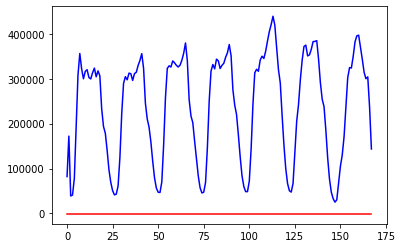

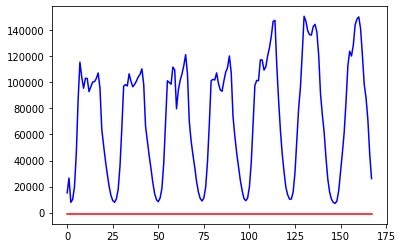

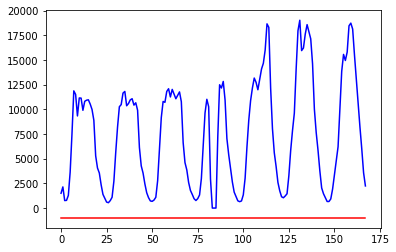

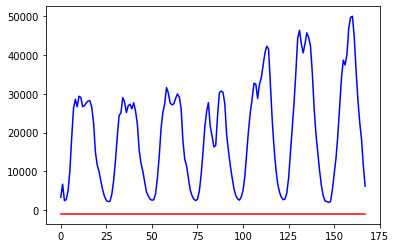

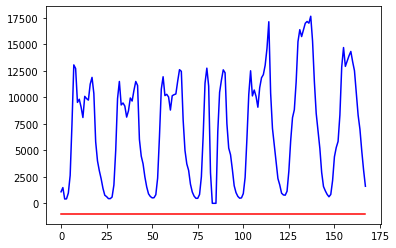

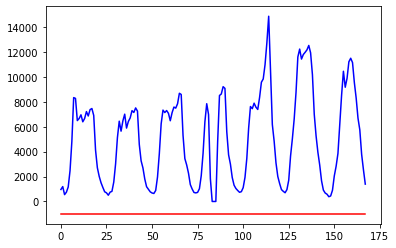

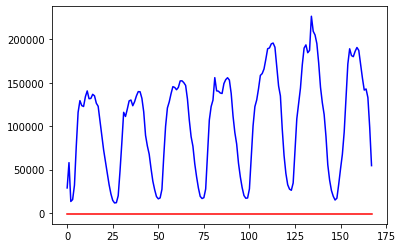

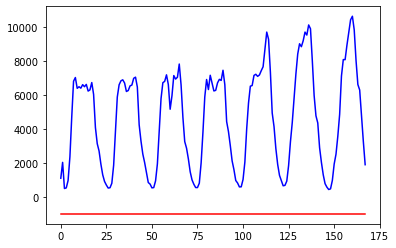

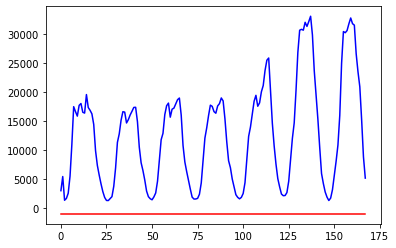

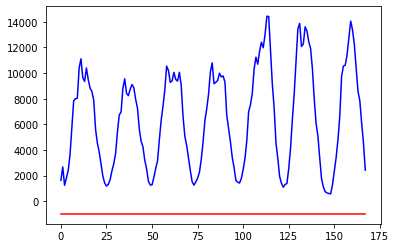

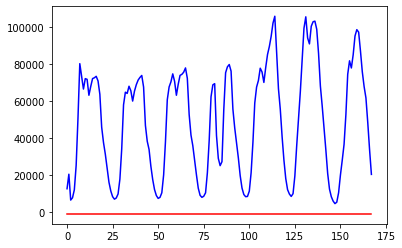

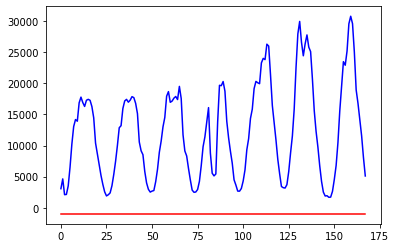

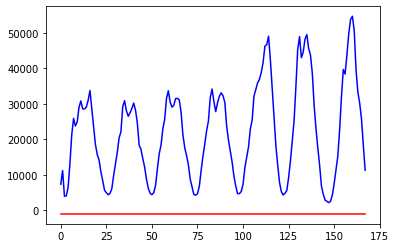

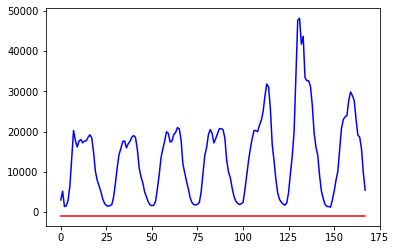

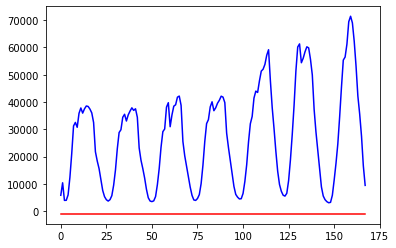

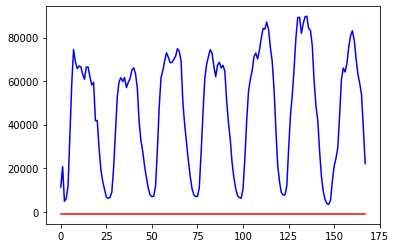

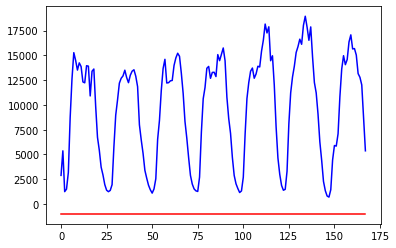

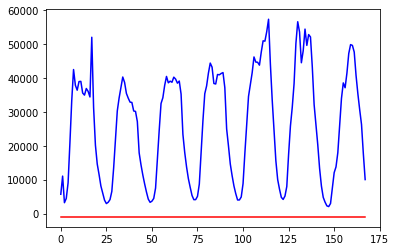

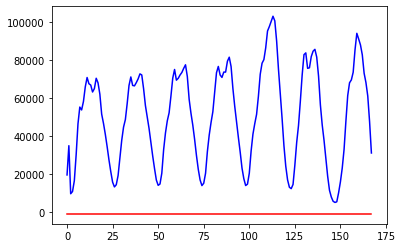

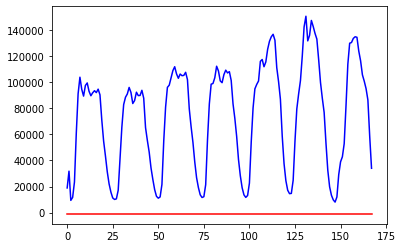

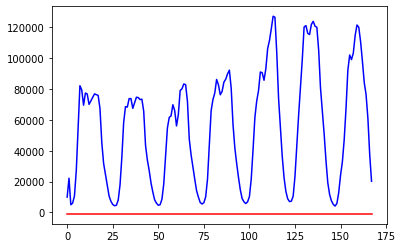

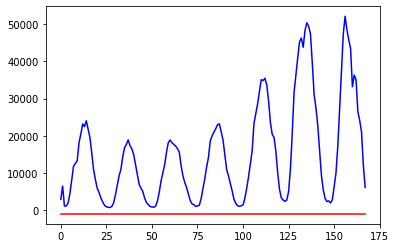

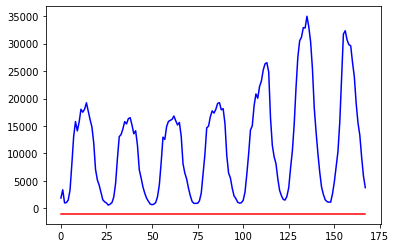

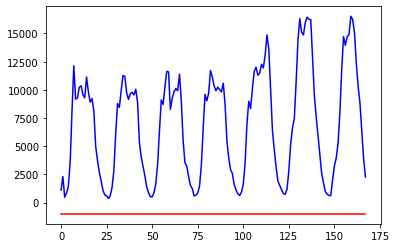

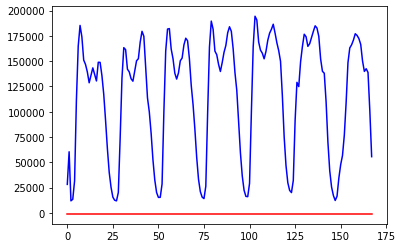

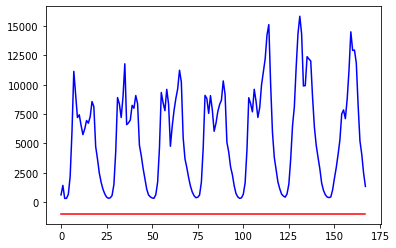

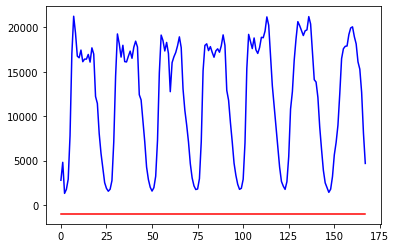

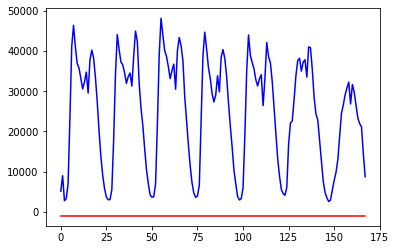

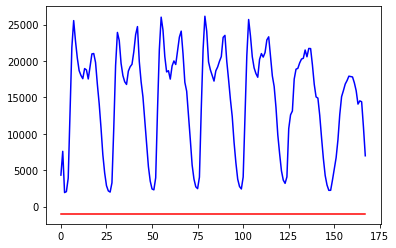

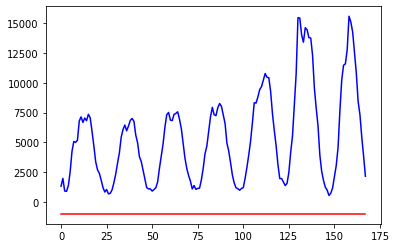

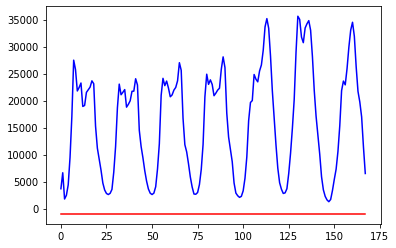

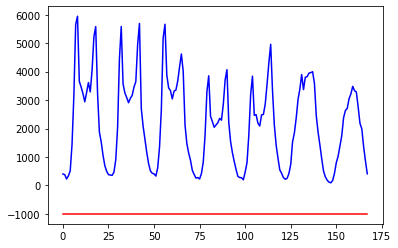

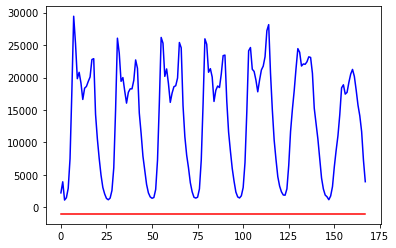

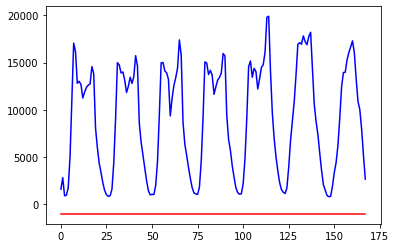

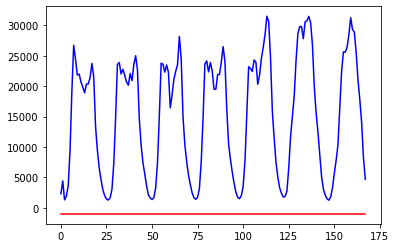

In [9]:
for i in range(len(road_cols)):
#     plt.plot(df_test[road_cols[i]][-168:].reset_index(drop = True), 'r')
    plt.plot(submit[[road_cols[i]]], 'b')
    
    plt.show()

In [10]:
submit.to_csv('MLP.csv', index = False)